In [1]:
import os 
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

from utils.visualization import plot_molecules, plot_molecule
from utils.preprocessing import get_average_trajectory_positions, get_time_distance_matrix
import processor.data as data_processor
import processor.graph as graph_processor
import utils.metrics as metrics
from utils.export import *

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU not available. Using CPU.


# Load data

In [4]:
integrin = "aVb3"    # "a5b1"
data_type = "clamp"  # Ramp 
u, extensions, config = data_processor.load_data(data_type, integrin)

In [5]:
# visualize 
t = 0
rep = 0

# set to first frame 
u[rep][extensions[t]].trajectory[0] 

plot_molecules(
    [
        u[rep][extensions[t]].select_atoms(f"protein and name CA").positions
    ]
)

# Define domains

In [6]:
# define domains 
ext = extensions[0]

if integrin == "aVb3":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-438").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 439-592").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 593-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-738").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-967").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 968-984").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 985-1016").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-56").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 57-108 or resid 353-433)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 109-352").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 434-436").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 437-472").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 473-522").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 523-559").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 560-600").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-695").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 696-725").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 726-763").atoms.resindices,
    }
    
elif integrin == "alphaVbeta3":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-438").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 439-592").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 593-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-738").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-956").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 957-984").atoms.resindices,
        # "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-967").atoms.resindices,
        # "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 968-984").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 985-1016").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-56").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 57-108 or resid 353-433)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 109-352").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 434-436").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 437-472").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 473-522").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 523-559").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 560-600").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-692").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 693-725").atoms.resindices,
        # "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-695").atoms.resindices,
        # "transmembrane-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 696-725").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 726-763").atoms.resindices,
    }
    
elif integrin == "a5b1":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-449").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 450-602").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 603-611").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 612-748").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 749-947").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 121-360").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 65-120 or resid 361-441)").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-64").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 442-444").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 445-480").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 481-533").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 534-570").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 571-610").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 611-703").atoms.resindices
    }
    
elif integrin == "alpha2bbeta3":
    # https://www.cell.com/molecular-cell/fulltext/S1097-2765(08)00839-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1097276508008393%3Fshowall%3Dtrue 
    # Zhu, Jianghai, et al. "Structure of a complete integrin ectodomain in a physiologic resting state and activation and deactivation by applied forces." Molecular cell 32.6 (2008): 849-861.
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-451").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 452-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-743").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 744-965").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 966-1080").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 989-1080").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1008-1063").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 1064-1115 or resid 1360-1440)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1116-1359").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1444-1479").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1480-1529").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1530-1566").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1567-1607").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1608-1699").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 1700-1732").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 1733-1770").atoms.resindices,
    }
else:
    domain_to_residues = {
        "molecule": u[0][ext].select_atoms(f"protein and name CA").atoms.resindices,
    }
    
residue_to_domain = {}
for domain, residues in domain_to_residues.items():
    for residue in residues:
        residue_to_domain[residue] = domain

domain_to_chain = {
    'beta-propeller': "A", 
    'thigh': "A", 
    'loopA': "A", 
    'calf1': "A", 
    'calf2': "A", 
    'transmembrane-alpha': "A", 
    'cytoplasmic-alpha': "A", 
    'psi': "B", 
    'hybrid': "B",
    'betaI': "B", 
    'loopB': "B", 
    'egf1': "B", 
    'egf2': "B", 
    'egf3': "B", 
    'egf4': "B", 
    'betaTD': "B", 
    'transmembrane-beta': "B", 
    'cytoplasmic-beta': "B"
}


# Construct graph

In [7]:
# construct molecular graph sequence 
graph_sequences, dygraph_sequences, resindices_to_index, dist_matrices = graph_processor.contruct_graph_dygraph(
    u=u,
    extensions=extensions,
    config=config,
    residue_to_domain=residue_to_domain,
    warm_up_frames=1,
    node_attributes="coords",
    bound_thd = 5, 
    pval_thd = 1e-5
)

ext: 3nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 957.59it/s]


There are 1623 residues and 801 timestamps
ext: 11nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1166.73it/s]


There are 1623 residues and 801 timestamps
ext: 16nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1368.47it/s]


There are 1623 residues and 801 timestamps
ext: 18nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1376.99it/s]


There are 1623 residues and 801 timestamps
start: 0
end: 3
nb_nodes:  1623
nb_interactions:  8625
ext: 3nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1372.85it/s]


There are 1623 residues and 801 timestamps
ext: 11nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1397.76it/s]


There are 1623 residues and 801 timestamps
ext: 16nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1368.60it/s]


There are 1623 residues and 801 timestamps
ext: 18nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1401.57it/s]


There are 1623 residues and 801 timestamps
start: 0
end: 3
nb_nodes:  1623
nb_interactions:  8626
ext: 3nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1204.21it/s]


There are 1623 residues and 801 timestamps
ext: 11nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1384.49it/s]


There are 1623 residues and 801 timestamps
ext: 16nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1380.66it/s]


There are 1623 residues and 801 timestamps
ext: 18nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1272.19it/s]


There are 1623 residues and 801 timestamps
start: 0
end: 3
nb_nodes:  1623
nb_interactions:  8671
ext: 3nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1217.06it/s]


There are 1623 residues and 801 timestamps
ext: 11nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1370.28it/s]


There are 1623 residues and 801 timestamps
ext: 16nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1414.61it/s]


There are 1623 residues and 801 timestamps
ext: 18nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1400.06it/s]


There are 1623 residues and 801 timestamps
start: 0
end: 3
nb_nodes:  1623
nb_interactions:  8659
ext: 3nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1375.78it/s]


There are 1623 residues and 801 timestamps
ext: 11nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1392.25it/s]


There are 1623 residues and 801 timestamps
ext: 16nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1361.99it/s]


There are 1623 residues and 801 timestamps
ext: 18nm
There are 1623 residues and 801 timestamps


100%|██████████| 800/800 [00:00<00:00, 1395.44it/s]


There are 1623 residues and 801 timestamps
start: 0
end: 3
nb_nodes:  1623
nb_interactions:  8656


# Run model

In [15]:
import torch
from models.gcn_diffpool import GCNDiffPool
import utils.graph_utils as graph_utils
from utils import metrics
import torch.optim as optim
from scipy import sparse
from training.train_diffpool import train
from collections import defaultdict
import networkx as nx

model_type = "diffpool"

In [ ]:
architecture = [16]
link_regularization = 10
ent_regularization = 1
dropout_rate = 0.0
n_clusters = 30
learning_rate = 0.0005
n_epochs = 300
min_nodes = 5

communities_list = [] 
residue_indices = list(resindices_to_index.keys())

Data shape: torch.Size([1623, 3]), adjacency shape: (1623, 1623)
==========Time 0 ==========
Total parameters: 590, Trainable parameters: 590
Epoch 0, Link Loss: 0.0015, Entropy Loss: 0.0164, Total Loss: 0.0179


/Users/lingchm/Documents/Github/DynMoCo/layers/diffpool.py:78: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 100, Link Loss: 0.0015, Entropy Loss: 0.0056, Total Loss: 0.0071
Epoch 200, Link Loss: 0.0015, Entropy Loss: 0.0053, Total Loss: 0.0069
Epoch 299, Link Loss: 0.0015, Entropy Loss: 0.0053, Total Loss: 0.0068
Modularity: 0.0000, Conductance: 0.0000
clusters (1623,)
[19 19 19 ... 19 19 19]


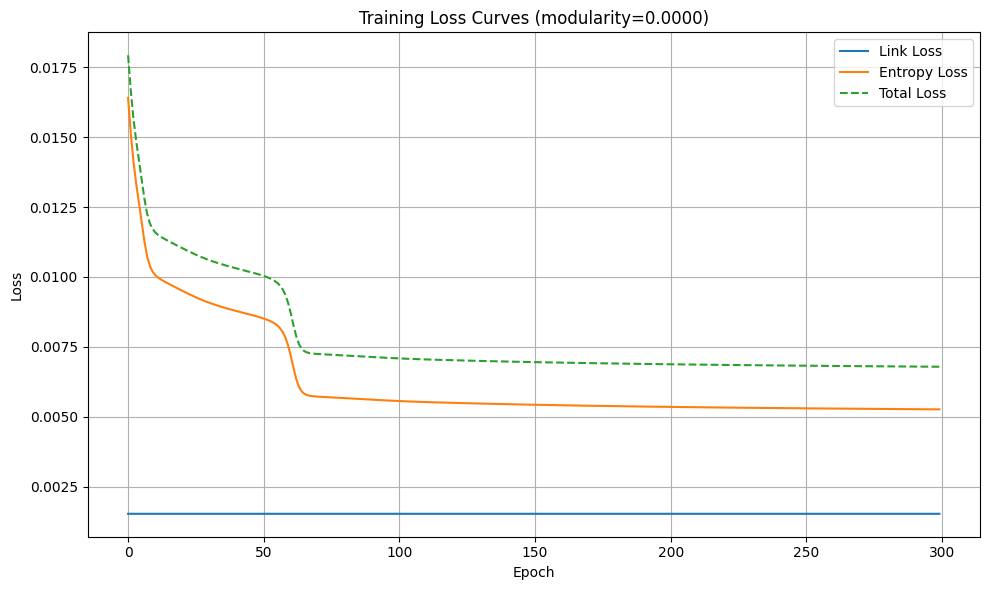

Total trainable parameters: 590
Total trainable parameters after frozen feature extractor: 510
Total of  1623 nodes assigned to 1 communities


In [28]:
rep = 0
graph_list = graph_sequences[rep]
communities = defaultdict(dict)
for t in range(len(extensions)-3):
    
    # Load and process the data
    adjacency = sparse.csr_matrix(nx.to_scipy_sparse_array(graph_list[t], format='csr'))
    features = torch.FloatTensor(np.array([graph_list[t].nodes[n]['feature'] for n in sorted(graph_list[t].nodes)]))
    if t == 0: print(f"Data shape: {features.shape}, adjacency shape: {adjacency.shape}")
    
    print("==========Time", t, "==========")
    
    # run model 
    if t == 0:
        clusters, model, modularity, assignments = train(adjacency, features, 
                                                    n_epochs = n_epochs, plot=True, architecture=architecture, 
                                                    link_regularization=link_regularization, ent_regularization=ent_regularization,
                                                    dropout_rate=dropout_rate, n_clusters=n_clusters, learning_rate=learning_rate, verbose=True)
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total trainable parameters: {total_params}")
        for param in model.gcn_layers.parameters():
            param.requires_grad = False
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total trainable parameters after frozen feature extractor: {total_params}")
    else:
        clusters, model2, modularity, assignments = train(adjacency, features, model, 
                                                    n_epochs = n_epochs//10, plot=True, architecture=architecture, 
                                                    link_regularization=link_regularization, ent_regularization=ent_regularization,
                                                    dropout_rate=dropout_rate, n_clusters=n_clusters, learning_rate=learning_rate, verbose=True)
    
    
    # exclude communities with too few nodes 
    unique, counts = np.unique(clusters, return_counts=True)
    communities_included = list(unique[counts >= min_nodes])
    mask = np.isin(clusters, communities_included)
    filtered_clusters = clusters[mask]
    filtered_nodes = np.nonzero(mask)[0]  # indices of kept nodes
    communities_included = [str(c) for c in communities_included]
    print("Total of ", filtered_nodes.shape[0], "nodes assigned to", len(communities_included), "communities")

    # store data 
    for i in range(len(clusters)):
        node = residue_indices[i]
        cluster = str(clusters[i])
        if cluster in communities_included:
            if node in communities[str(cluster)]:
                communities[str(cluster)][node].append(t)
            else:
                communities[str(cluster)][node] = [t]

In [21]:
# run the above for n_rep times 
communities_list.append(communities)

In [22]:
# Export to json 
communities_list = [convert_keys_to_builtin(c) for c in communities_list]
os.makedirs(f'results/{model_type}/{integrin}_{data_type}', exist_ok=True)
with open(f'results/{model_type}/{integrin}_{data_type}/communities_raw.json', 'w') as f:
    json.dump(communities_list, f, indent=4)